<a href="https://colab.research.google.com/github/mikodham/CS470/blob/main/BaselineCode_Gideb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [1]:
''' INITIALIZATION '''
# 1st option, upload on ur gdrive
# from google.colab import files
# files.upload()
# 2nd option, just drag the folder from your folder to drive/content/

import os 
import urllib
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
password = urllib.parse.quote(password)
os.environ['GITHUB_AUTH'] = user + ':' + password
del password

# 3rd option, git clone
!pwd
!rm -rf descry-gideb_trial  # FOR UPDATING DATASET DO NOT RUN THIS LINE
!git clone https://$GITHUB_AUTH@github.com/mikodham/descry-gideb_trial.git 

del os.environ['GITHUB_AUTH']


GitHub user··········
GitHub password··········
/content
Cloning into 'descry-gideb_trial'...
remote: Enumerating objects: 3941, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 3941 (delta 87), reused 182 (delta 82), pack-reused 3754
Receiving objects: 100% (3941/3941), 548.97 MiB | 40.42 MiB/s, done.
Resolving deltas: 100% (453/453), done.


In [2]:
#Set-up Directory
gitdir = os.path.join(os.getcwd(), "descry-gideb_trial")
gitdir


'/content/descry-gideb_trial'

In [3]:
#REQUIREMENTS, #don't forget to turn on gpu
!pip3 install sklearn gensim xgboost keras konlpy~=0.5.2 emoji
!pip3 install nltk~=3.5
!sudo apt-get install g++ openjdk-8-jdk curl
!pip3 install -r descry-gideb_trial/requirements.txt


     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 184 kB 68.0 MB/s 
     |████████████████████████████████| 448 kB 57.1 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=1f3d7fe28535c258ffce3ba3c80d5186039cc24f203467da4f443325a8b6a60d
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 1.5 MB 7.5 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is 

In [4]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import argparse
import emoji
import re

2.5.0


In [5]:
import nltk
import konlpy 
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [6]:
import random
# DO NOT EDIT THE FOLLOWING LINES
# THESE LINES ARE FOR REPRODUCIBILITY
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

#PREPROCESSING
1. Load Dataset
2. Pre-process sentence into features



#EXTRACT DATASET: TRAIN+TEST



In [7]:
#Datastructure to  extract dataset

def load_dataset(files, cols, positive=False):
  '''
  files = list of path files
  cols = usecols (e.g cols="B,E" or "B:E")
  positive = True when loading suicidal-only dataset without ground truth
  return master_df
  '''
  master_df = pd.DataFrame()
  for file in files:
    dfs = pd.read_excel(file,sheet_name=[0],usecols=cols,skiprows=[]) # 1 dataframe for each sheet within an excel file
    df = pd.concat(dfs,ignore_index=True) # merging the dataframes for each sheet
    master_df = pd.concat([master_df,df],ignore_index=True) # merging the dataframes for each file
  del dfs, df

  # Clean Dataset
  if positive:
    master_df.loc[:,"Ground-Truth"] = True
    # df_all = pd.concat([master_df, new_gt], axis=1)
  else:
    keys = master_df.keys().tolist()
    master_df[keys[1]] = (master_df[keys[1]] == 'Y').astype(bool)

  keys = master_df.keys().tolist()
  print("keys are ", keys)
  #rename ground truth class as not-key, but "ground-truth"
  master_df = master_df.rename(columns={keys[0]: "Sentence"}) 
  master_df = master_df.rename(columns={keys[1]: "Ground-Truth"})

  master_df.dropna(subset = ["Sentence"], inplace=True) 
  return master_df


def combine(dfa, dfb):
  return pd.concat([dfa, dfb], axis=0).sample(frac=1).reset_index(drop=True)


def get_posneg(master_df, positive=5, negative=5, key_loc=1):
  """
  master_df= original df that needs to be splitted
  positive= how many positive suicidal sentence to extract
  negative= how many non-suicidal sentence to extract
  condition = 
  Return df_all: with Ground truth
  """
  df_positives = master_df[master_df[master_df.keys()[1]].isin([True])]
  df_negatives = master_df[master_df[master_df.keys()[1]].isin([False])]
  # # df_negatives.reset_index(drop=True,inplace=True)
  if positive==0 and negative==0:
      raise ValueError("no sample is taken")
  if positive==0:
      df_all = df_negatives.sample(negative)
  elif negative==0:
      df_all = df_positives.sample(positive)
  else:
      df_all = pd.concat([df_positives.sample(positive), df_negatives.sample(negative)], axis=0)
  print("shapes: ", len(df_positives.index), len(df_negatives.index))
  print("shape: ", len(df_all.index))
  df_all = df_all.sample(frac=1).reset_index(drop=True) # Randomize
  # print(df_positives.head(10))
  return df_all


def split(master_df, train=10, test=10, percent=None):
  """
  split training and test
  Return train_features, train_truth, test_features, test_truth
  """
  if percent==None:
    pass
    #set train and test
  #split

  return train_features, train_truth, test_features, test_truth



In [8]:
train_files = [
  # TODO: Warn: Format is different need to change xlsx file labels
  os.path.join(gitdir, "dataset", "Scraping_4th_week_of_Fed_Suicidal.xlsx"), # the correct data  
]

data_df = load_dataset(files=train_files, cols="B,E", positive=False)
# data_df
train_files = [
  # TODO: Warn: Format is different need to change xlsx file labels
  os.path.join(gitdir, "dataset", "Suicidal Texts Compilation (All Y's).xlsx")
]
data2_df = load_dataset(files=train_files, cols="B", positive=True)

data_df = combine(data_df, data2_df)


test_files = [
  os.path.join(gitdir, "dataset", "핵심 단어 목록.xlsx")
]

keys are  ['Post/Sentence', 'Suicidal (Y/N)']
keys are  ['Post/Sentence', 'Ground-Truth']


In [9]:
data_df

,Sentence,Ground-Truth
0,미래를 생각하면 막막하고 과연 이게 해결이될까 불안하시겠지만 지금이라도 본인의 상황...,False
1,공감하는글이네요\n\n,False
2,사진은 제가 2016년 1월인가 때 했었던 IQ 검사 결과지입니다.\n병전 지능은 ...,False
3,상위나 기초생활수급이나 등등\n다른 복지도 함께 알아보세요,False
4,"너무 지쳤어요.. \n 요새..식욕도 줄었고,잠도 줄었고..우울하고,힘들어요.. 눈...",True
...,...,...
2414,네~아마 조증 예방 주사인것 같습니다 ^^,False
2415,맞아요.. 저희아빠도 그래요... 자기가 정말 병인데 인지를 잘 안하세요 ㅜㅜㅜ\n...,False
2416,감사합니다. 많이 위로가됐습니다.. 저위해 희생해주는사람 꾹믿고 부딪혀보도록노력하겟...,False
2417,아직 진료일이 좀 남았는데\n\n제가 우울증이다가 조울이란 생각이 들기 시작했어요\...,False


In [10]:
#Learn How to iterate those
# df_negatives.iloc[100] #text:[0], class:[1]
# df_positives #reddit post and suicide risk
# df_negatives[keys[1]]

##Dataset Tensorflow

In [11]:
# TODO: Find the right data structure to match tensorflow dataset, so that the train and test data
# will be trainable

# Reference: https://www.tensorflow.org/datasets/add_dataset
# TODO: Later, for more Classifications, need custom datasets
# Negative: Q불안장애Anxiety, W트라우마PTSD, E우울증Depression, R조울증Bipolar, T강박장애OCD, Y무기력Lethargy, U과잉행동장애ADHD, I공황장애Panic disorder
# Positive: A응원Encourage S극복Overcome D다짐Decide F추억Remind G깨달음Realized H감사Gratitude J사과Apology K고백Confession L용서Forgiveness

#Features Extraction

In [12]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

kkma = konlpy.tag.Kkma()

In [13]:
#TESTING KONLPY
'''

# every = "my name is 미코. 제가 21살이야. 반갑습니다"
every = "집에 오면 내 편은 아무도 없고 우울하기만 합니다 어떻게 해야 할까요"
every = "생각많은것도 에너지 고갈된다😣😓, 노래듣고 재밌는 프로 보면서 즐겁게 쉬자🔥"
# every = "마인드까페👍 상담사님들👍💕" # KKMA can't work on emoticons, why? KKMA uses UTF-8!

#1st try
every = '생각많은것도 에너지 고갈된다😣😓, 노래듣고😣😓 재밌는 프로 보면서 즐겁게 쉬자🔥'
print("tokens: ", nltk.word_tokenize(every))
print(len(every), every.split()) #emoticon is not alphabet, korean texts ARE
print(every.split()[0].isalpha())
after = every.encode('latin1', errors = "replace")
print(type(after))
POS = kkma.pos(after)
# print(after.decode("utf-8"))
 # 'latin-1''utf-8' 'unicode-escape' ("utf-8", errors = "replace")
print(POS) # ERROR
#2 
#we can define emoticon as new feature later
# count number of emoticons
# for char in every
import emoji
import re

emojis = ''.join(c for c in every if c in emoji.UNICODE_EMOJI['en'])
non_emoji_sents = deEmojify(every)
POS = kkma.pos(non_emoji_sents)
print("FINAL POS", POS)

text = "입맛이 없고 나른해지면서 아무 생각이 없어지는 걸 보니 울기가 시작되려나 보네요 일찍 병원에 갔다가 다시 약조절 하고 간만에 스벅 왔는데 그 좋아하는 샌드위치를 봐도 감흥이 없어요 이 시기에 살이나 빼야겠어요 다들 주말 무사히 보내세요~"
POS = kkma.pos(text)
POS # ~ has POS of "SO"
'''

'\n\n# every = "my name is 미코. 제가 21살이야. 반갑습니다"\nevery = "집에 오면 내 편은 아무도 없고 우울하기만 합니다 어떻게 해야 할까요"\nevery = "생각많은것도 에너지 고갈된다😣😓, 노래듣고 재밌는 프로 보면서 즐겁게 쉬자🔥"\n# every = "마인드까페👍 상담사님들👍💕" # KKMA can\'t work on emoticons, why? KKMA uses UTF-8!\n\n#1st try\nevery = \'생각많은것도 에너지 고갈된다😣😓, 노래듣고😣😓 재밌는 프로 보면서 즐겁게 쉬자🔥\'\nprint("tokens: ", nltk.word_tokenize(every))\nprint(len(every), every.split()) #emoticon is not alphabet, korean texts ARE\nprint(every.split()[0].isalpha())\nafter = every.encode(\'latin1\', errors = "replace")\nprint(type(after))\nPOS = kkma.pos(after)\n# print(after.decode("utf-8"))\n # \'latin-1\'\'utf-8\' \'unicode-escape\' ("utf-8", errors = "replace")\nprint(POS) # ERROR\n#2 \n#we can define emoticon as new feature later\n# count number of emoticons\n# for char in every\nimport emoji\nimport re\n\nemojis = \'\'.join(c for c in every if c in emoji.UNICODE_EMOJI[\'en\'])\nnon_emoji_sents = deEmojify(every)\nPOS = kkma.pos(non_emoji_sents)\nprint("FINAL POS", POS)\n\ntext = "입맛이 없고

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def get_all_tags(data):
    print("Processing POS features ...")
    tags_all = []
    for title in data:
        emojis = ''.join(c for c in title if c in emoji.UNICODE_EMOJI['en'])
        non_emoji_sents = deEmojify(title)
        tagged_text = kkma.pos(non_emoji_sents)
        # tagged_text = kkma.pos(title)
        for word, tag in tagged_text:
            if tag not in tags_all:
                tags_all.append(tag)
    return tags_all


def f_pos(data, tags_all):
    tag_dict, tag_count = {}, {}
    for tag in tags_all:
        tag_dict[tag] = 0
        tag_count[tag] = []
    for title in data:
        # every = nltk.word_tokenize(title)      
        # print(title)
        emojis = ''.join(c for c in title if c in emoji.UNICODE_EMOJI['en'])
        non_emoji_sents = deEmojify(title)
        tagged_text = kkma.pos(non_emoji_sents)
        # tagged_text = kkma.pos(title) # tagged_text = nltk.pos_tag(nltk.word_tokenize(title)) 
        for word, tag in tagged_text:
            tag_dict[tag]+=1
        for count,tag in zip(tag_dict.values(), tag_dict.keys()):
            tag_count[tag].append(count)
    return pd.DataFrame(tag_count, index=None)


def f_basic(data):
    print("Processing basic features ...")
    num_title_words, num_title_token, num_title_char, num_emojis = [], [], [], []
    for title in data:
        num_title_words.append(len(title.split()))
        # print(title) #avoid emoticons
        emojis = ''.join(c for c in title if c in emoji.UNICODE_EMOJI['en'])
        non_emoji_sents = deEmojify(title)
        tagged_text = kkma.pos(non_emoji_sents)
        tokens = [word for word, tag in tagged_text]
        num_title_token.append(len(tokens))
        num_title_char.append(len(title))
        num_emojis.append(len(emojis))
    print("Processing basic features ... Almost Done")
    features = {'title_words': num_title_words, 'title_token': num_title_token, 'title_char': num_title_char,'title_emojis': num_emojis}
    print("Processing basic features ... Done")
    return pd.DataFrame(features, columns=['title_words', 'title_token', 'title_char','title_emojis'])


def f_tfidf(data):
    print("Processing TF-IDF features ...")
    X = data
    count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=50)
    X_counts = count_vect.fit_transform(X)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_counts)
    df_tfidf = pd.DataFrame(X_train_tfidf.todense())
    return df_tfidf

  
def features(data): ### Features Extraction 
  df_basic = f_basic(data)
  df_tfidf = f_tfidf(data)
  tags_all = get_all_tags(data)
  df_pos = f_pos(data, tags_all)
  df_features = pd.concat([df_basic,  df_pos], axis=1) \
  #df_tfidf # NOTE THAT TF IDF IS NOT INCLUDED
  return df_features

# Run Features IGNORE FOR NOW

In [15]:
# list(df_negatives_zenodo['Reddit Post'])

# def get_zenodo(n_train, n_valid, n_pred): 
'''
n_train,  n_pred = 500, 700

  zenodo: Negative 1609 ['supportive','uninformative']
          Positive 778 ['attempt','behavior','indicator','ideation']
  Index of Extraction: n_train < n_pred
  Maximum n_pred is 750
  Return Dataset for 6 classifications, balanced data between positive and negative

import random
if n_pred > 750: raise AssertionError("n_pred exceeds")
if (n_train < n_pred) is False: raise AssertionError("Input Order Error")
positive_sents = list(df_positives_zenodo['Reddit Post'][:n_pred])
# print(type(positive_sents))
negative_sents = list(df_negatives_zenodo['Reddit Post'][:n_pred])
extracted_sentences = positive_sents + negative_sents # list of all sentences in the corpus
extracted_sentences = [str(sent) for sent in extracted_sentences] 

extracted_labels = list(df_positives_zenodo['Suicide Risk'][:n_pred])
extracted_labels += list(df_negatives_zenodo['Suicide Risk'][:n_pred])
labels = ['supportive','uninformative','attempt','behavior','indicator','ideation']
extracted_labels = [labels.index(each) for each in extracted_labels]

# Shuffle
seed = random.random()
random.seed(seed) 
random.shuffle(extracted_sentences)
random.seed(seed)
random.shuffle(extracted_labels)
# # Shuffle
# indices = np.arange(extracted_sentences.shape[0])
# np.random.shuffle(indices)
# extracted_sentences = extracted_sentences[indices]
# extracted_labels = extracted_labels[indices]

# TRAIN
train_sentences = extracted_sentences[:n_train]
train_labels = extracted_labels[:n_train]

# TEST
test_sentences = extracted_sentences[n_train:n_pred]
test_labels = extracted_labels[n_train:n_pred]
# print(corY_labels)
# Should I convert into digits of classes?
'''



'\nn_train,  n_pred = 500, 700\n\n  zenodo: Negative 1609 [\'supportive\',\'uninformative\']\n          Positive 778 [\'attempt\',\'behavior\',\'indicator\',\'ideation\']\n  Index of Extraction: n_train < n_pred\n  Maximum n_pred is 750\n  Return Dataset for 6 classifications, balanced data between positive and negative\n\nimport random\nif n_pred > 750: raise AssertionError("n_pred exceeds")\nif (n_train < n_pred) is False: raise AssertionError("Input Order Error")\npositive_sents = list(df_positives_zenodo[\'Reddit Post\'][:n_pred])\n# print(type(positive_sents))\nnegative_sents = list(df_negatives_zenodo[\'Reddit Post\'][:n_pred])\nextracted_sentences = positive_sents + negative_sents # list of all sentences in the corpus\nextracted_sentences = [str(sent) for sent in extracted_sentences] \n\nextracted_labels = list(df_positives_zenodo[\'Suicide Risk\'][:n_pred])\nextracted_labels += list(df_negatives_zenodo[\'Suicide Risk\'][:n_pred])\nlabels = [\'supportive\',\'uninformative\',\'at

In [16]:
# vocab_size, bow_features, tfidf_features = BOW_TFIDF(train_sentences)
# #Warning: This takes a long Time!

# print(tfidf_features[200])

# Model: RNN

In [18]:
def arg_rnn():
    parser = argparse.ArgumentParser()
    parser.add_argument('--max_seq_len', type=int, default=1000, help="max length of sequences")
    parser.add_argument('--max_num_words', type=int, default=20000, help="max number of words")
    parser.add_argument('-d', '--embedding_dim', type=int, default=300, help="embedding dimension")
    parser.add_argument('--rnn_units', type=int, default=128, help="units of RNN")
    parser.add_argument('--dropout_rate', type=float, default=0.1, help='dropout rate')
    parser.add_argument('--dense_units', type=int, default=32, help="units of Dense layer")
    parser.add_argument('--embedding_type', type=str, default='word2vec', help="the type of word embedding")
    parser.add_argument('--valid_split', type=float, default=0.1, help="ratio of validation split")
    parser.add_argument('-act', '--activation', type=str, default='relu', help="type of activation function")
    parser.add_argument('--patience', type=int, default=10, help="number of epochs with no improvement after which training will be stopped")
    parser.add_argument('--batch_size', type=int, default=64, help="batch size")
    parser.add_argument('--epochs', type=int ,default=20, help="training epochs")
    # args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    return args

In [19]:
def build_RNN(args):
    model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=100000, output_dim = args.embedding_dim), 
      tf.keras.layers.SimpleRNN(128, return_sequences=True),
      tf.keras.layers.GlobalMaxPool1D(),
      # tf.keras.layers.Dropout(args.dropout_rate),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(args.dense_units, activation="relu"),
      # tf.keras.layers.Dropout(args.dropout_rate),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation="sigmoid")
      # layers.Embedding(input_dim=len(vocabulary) + 2, output_dim=32,),
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])#sparse_categorical_crossentropy #accuracy
    return model

In [ ]:
# def build_RNN(args):
#     # TODO: Tim, please modify this part use tf.keras instead of keras.model
#     # model = tf.keras.Sequential([
#     #     tf.keras.layers.Dense(16,activation='relu',input_shape=(NUM_WORDS,)),
#     # ])
#     # inp1 = tf.keras.layers.Input(shape=(args.max_seq_len, ))
#     # inp2 = tf.keras.layers.Input(shape=(args.max_seq_len, ))
#     model = tf.keras.Sequential([
#       tf.keras.layers.Embedding(vocab_size, args.embedding_dim), 
#       # x2 = tf.keras.layers.Embedding(args.max_num_words, args.embedding_dim)(inp2)
#       tf.keras.layers.SimpleRNN(128, return_sequences=True),
#       # x2 = tf.keras.layers.SimpleRNN(args.rnn_units, return_sequences=True)(x2)
#       # x = tf.keras.layers.concatenate([x1, x2])
#       tf.keras.layers.GlobalMaxPool1D(),
#       tf.keras.layers.Dropout(args.dropout_rate),
#       tf.keras.layers.BatchNormalization(),
#       tf.keras.layers.Dense(args.dense_units, activation="relu"),
#       tf.keras.layers.Dropout(args.dropout_rate),
#       tf.keras.layers.BatchNormalization(),
#       tf.keras.layers.Dense(1, activation="sigmoid")
#       # model = tf.keras.models.Model(inputs=[inp1, inp2], outputs=x)
#     ])
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [20]:
# PLOT EVALUATION

def evaluate(history):
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training Loss')
  plt.xlabel('epoch')
  plt.show()

#Execution

In [21]:
#set inp and inn in datatrain_conf
datatrain_conf = list()
for inp in [40,70,100,130,160, 190, 210]:
  datatrain_conf.append((inp, inp))
for inn in [40,70,100,130,160, 190, 210, 280, 350, 420, 560, 700, 900, 1200]:
  datatrain_conf.append((210, inn))
print(datatrain_conf)

[(40, 40), (70, 70), (100, 100), (130, 130), (160, 160), (190, 190), (210, 210), (210, 40), (210, 70), (210, 100), (210, 130), (210, 160), (210, 190), (210, 210), (210, 280), (210, 350), (210, 420), (210, 560), (210, 700), (210, 900), (210, 1200)]


In [22]:
# EXECUTION DATASET
result = [] # (test accuracy, test loss)
len(datatrain_conf)
import time
start = time.time()
print("TIME TAKEN %f\n" % (time.time()-start))

TIME TAKEN 0.000062



TRAINING WITH INP 40 and INN 40, TRIAL 0/n
shapes:  211 2208
shape:  80
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
2/2 [==============================] - 6s 1s/step - loss: 0.8504 - binary_accuracy: 0.5156 - val_loss: 0.6878 - val_binary_accuracy: 0.5000
Epoch 2/2
2/2 [==============================] - 1s 701ms/step - loss: 0.1793 - binary_accuracy: 0.9844 - val_loss: 0.6882 - val_binary_accuracy: 0.5000
TRAINING DONE


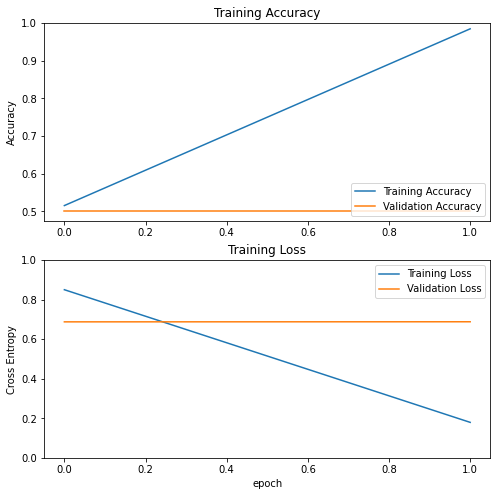

4/4 [==============================] - 0s 7ms/step - loss: 0.7298 - binary_accuracy: 0.2100
Test accuracy: 0.2100
Test loss: 0.7298
TIME TAKEN 91.629117

TRAINING WITH INP 40 and INN 40, TRIAL 1/n
shapes:  211 2208
shape:  80
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
2/2 [==============================] - 3s 557ms/step - loss: 0.8103 - binary_accuracy: 0.5312 - val_loss: 0.6897 - val_binary_accuracy: 0.5625
Epoch 2/2
2/2 [==============================] - 1s 338ms/step - loss: 0.1397 - binary_accuracy: 0.9844 - val_loss: 0.6915 - val_binary_accuracy: 

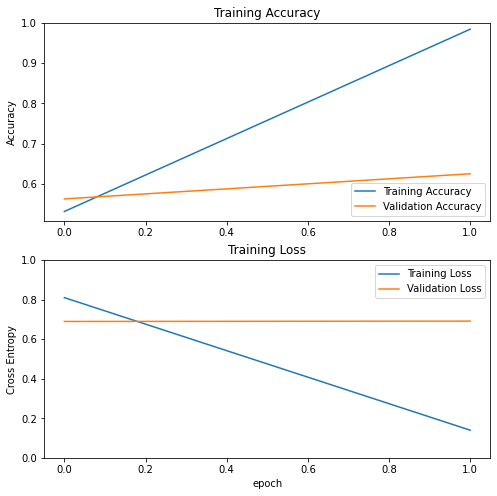

4/4 [==============================] - 0s 8ms/step - loss: 0.6896 - binary_accuracy: 0.4800
Test accuracy: 0.4800
Test loss: 0.6896
TIME TAKEN 65.752238

TRAINING WITH INP 70 and INN 70, TRIAL 0/n
shapes:  211 2208
shape:  140
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
4/4 [==============================] - 3s 392ms/step - loss: 0.8516 - binary_accuracy: 0.5000 - val_loss: 0.7048 - val_binary_accuracy: 0.5357
Epoch 2/2
4/4 [==============================] - 1s 330ms/step - loss: 0.1764 - binary_accuracy: 0.9821 - val_loss: 0.6947 - val_binary_accuracy:

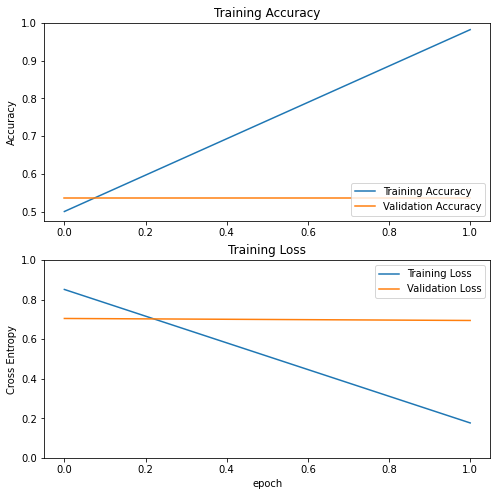

4/4 [==============================] - 0s 8ms/step - loss: 0.7892 - binary_accuracy: 0.0200
Test accuracy: 0.0200
Test loss: 0.7892
TIME TAKEN 107.695019

TRAINING WITH INP 70 and INN 70, TRIAL 1/n
shapes:  211 2208
shape:  140
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
4/4 [==============================] - 3s 388ms/step - loss: 0.8618 - binary_accuracy: 0.4911 - val_loss: 0.7152 - val_binary_accuracy: 0.4286
Epoch 2/2
4/4 [==============================] - 1s 312ms/step - loss: 0.1897 - binary_accuracy: 0.9911 - val_loss: 0.7075 - val_binary_accuracy

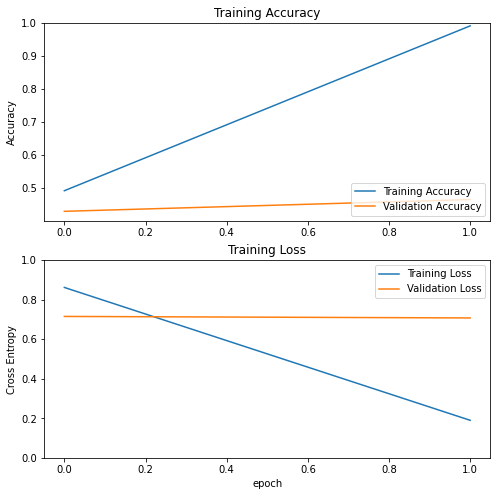

4/4 [==============================] - 0s 8ms/step - loss: 0.5999 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.5999
TIME TAKEN 109.933211

TRAINING WITH INP 100 and INN 100, TRIAL 0/n
shapes:  211 2208
shape:  200
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
5/5 [==============================] - 4s 367ms/step - loss: 0.8336 - binary_accuracy: 0.5875 - val_loss: 0.6919 - val_binary_accuracy: 0.5500
Epoch 2/2
5/5 [==============================] - 2s 315ms/step - loss: 0.1541 - binary_accuracy: 0.9812 - val_loss: 0.6905 - val_binary_accura

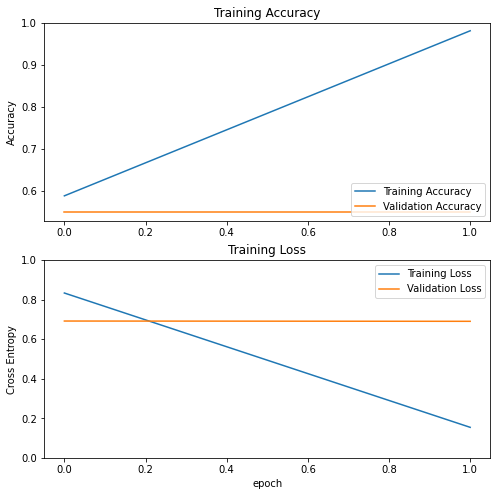

4/4 [==============================] - 0s 8ms/step - loss: 0.8440 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.8440
TIME TAKEN 140.834592

TRAINING WITH INP 100 and INN 100, TRIAL 1/n
shapes:  211 2208
shape:  200
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
5/5 [==============================] - 4s 365ms/step - loss: 0.9398 - binary_accuracy: 0.4875 - val_loss: 0.7110 - val_binary_accuracy: 0.4500
Epoch 2/2
5/5 [==============================] - 2s 311ms/step - loss: 0.1720 - binary_accuracy: 0.9688 - val_loss: 0.7028 - val_binary_ac

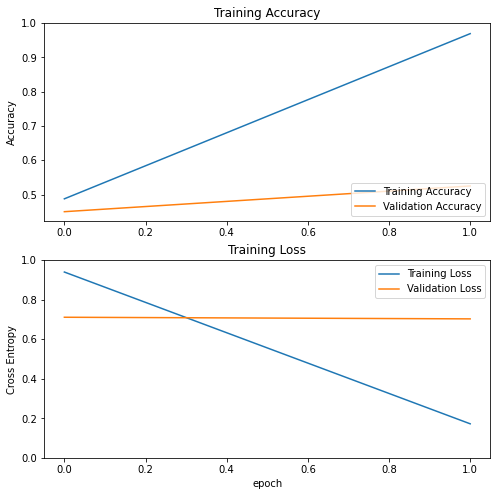

4/4 [==============================] - 0s 8ms/step - loss: 0.6521 - binary_accuracy: 0.8000
Test accuracy: 0.8000
Test loss: 0.6521
TIME TAKEN 137.292835

TRAINING WITH INP 130 and INN 130, TRIAL 0/n
shapes:  211 2208
shape:  260
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
7/7 [==============================] - 4s 348ms/step - loss: 0.9018 - binary_accuracy: 0.5385 - val_loss: 0.6938 - val_binary_accuracy: 0.5962
Epoch 2/2
7/7 [==============================] - 2s 314ms/step - loss: 0.2143 - binary_accuracy: 0.9327 - val_loss: 0.6852 - val_binary_accura

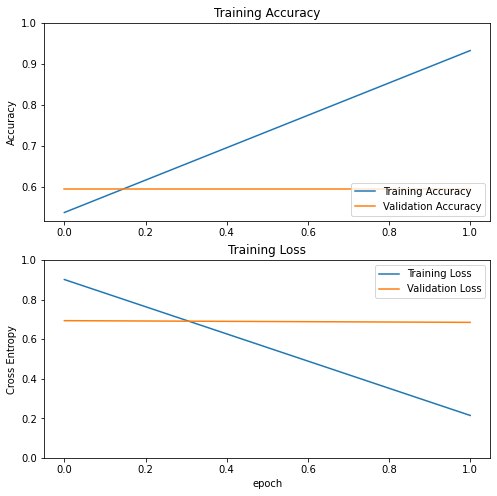

4/4 [==============================] - 0s 8ms/step - loss: 0.4322 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.4322
TIME TAKEN 171.316812

TRAINING WITH INP 130 and INN 130, TRIAL 1/n
shapes:  211 2208
shape:  260
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
7/7 [==============================] - 4s 359ms/step - loss: 1.0529 - binary_accuracy: 0.4808 - val_loss: 0.6963 - val_binary_accuracy: 0.5385
Epoch 2/2
7/7 [==============================] - 3s 451ms/step - loss: 0.1923 - binary_accuracy: 0.9519 - val_loss: 0.6946 - val_binary_accura

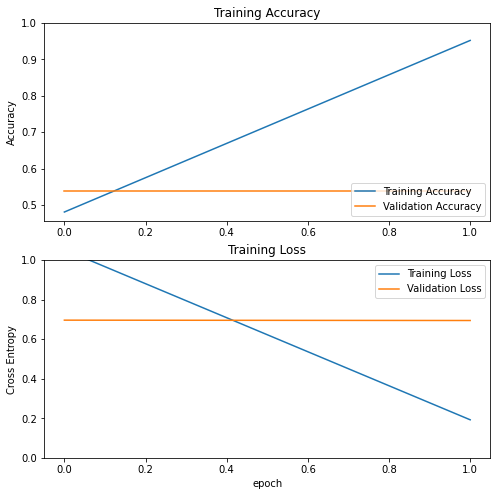

4/4 [==============================] - 0s 8ms/step - loss: 0.4992 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.4992
TIME TAKEN 184.515692

TRAINING WITH INP 160 and INN 160, TRIAL 0/n
shapes:  211 2208
shape:  320
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
8/8 [==============================] - 4s 342ms/step - loss: 0.9271 - binary_accuracy: 0.5078 - val_loss: 0.7699 - val_binary_accuracy: 0.5000
Epoch 2/2
8/8 [==============================] - 2s 311ms/step - loss: 0.2114 - binary_accuracy: 0.9414 - val_loss: 0.7512 - val_binary_accura

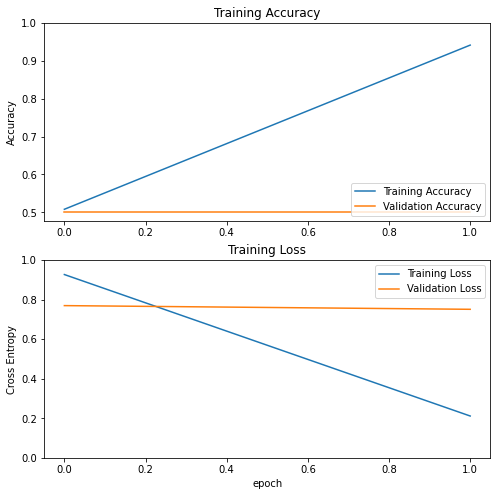

4/4 [==============================] - 0s 9ms/step - loss: 0.4137 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.4137
TIME TAKEN 216.370361

TRAINING WITH INP 160 and INN 160, TRIAL 1/n
shapes:  211 2208
shape:  320
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
8/8 [==============================] - 4s 344ms/step - loss: 0.9470 - binary_accuracy: 0.4375 - val_loss: 0.6966 - val_binary_accuracy: 0.4844
Epoch 2/2
8/8 [==============================] - 3s 313ms/step - loss: 0.2493 - binary_accuracy: 0.9297 - val_loss: 0.6930 - val_binary_accura

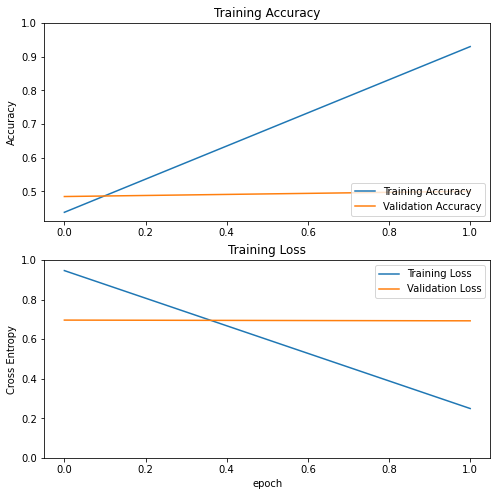

4/4 [==============================] - 0s 11ms/step - loss: 0.6059 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.6059
TIME TAKEN 216.676035

TRAINING WITH INP 190 and INN 190, TRIAL 0/n
shapes:  211 2208
shape:  380
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
10/10 [==============================] - 5s 345ms/step - loss: 0.8773 - binary_accuracy: 0.5033 - val_loss: 0.7498 - val_binary_accuracy: 0.3947
Epoch 2/2
10/10 [==============================] - 3s 318ms/step - loss: 0.2416 - binary_accuracy: 0.9211 - val_loss: 0.7266 - val_binary_a

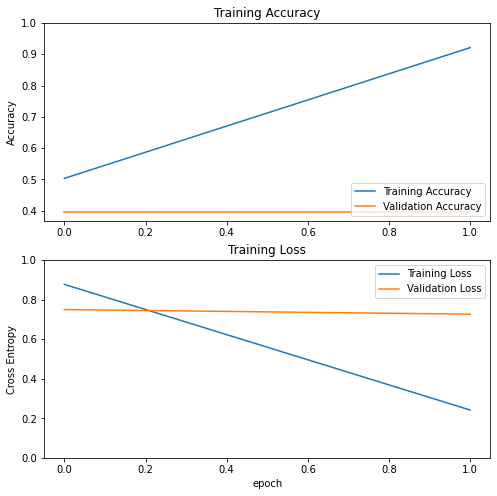

4/4 [==============================] - 0s 8ms/step - loss: 0.5763 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.5763
TIME TAKEN 253.672075

TRAINING WITH INP 190 and INN 190, TRIAL 1/n
shapes:  211 2208
shape:  380
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
10/10 [==============================] - 6s 358ms/step - loss: 0.8654 - binary_accuracy: 0.5132 - val_loss: 0.7022 - val_binary_accuracy: 0.3947
Epoch 2/2
10/10 [==============================] - 3s 326ms/step - loss: 0.2530 - binary_accuracy: 0.9342 - val_loss: 0.7038 - val_binary_ac

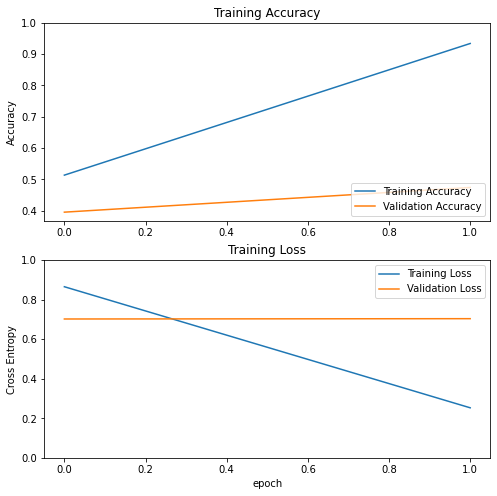

4/4 [==============================] - 0s 9ms/step - loss: 0.7979 - binary_accuracy: 0.0400
Test accuracy: 0.0400
Test loss: 0.7979
TIME TAKEN 263.550867

TRAINING WITH INP 210 and INN 210, TRIAL 0/n
shapes:  211 2208
shape:  420
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
11/11 [==============================] - 8s 336ms/step - loss: 0.8558 - binary_accuracy: 0.5536 - val_loss: 0.7009 - val_binary_accuracy: 0.4881
Epoch 2/2
11/11 [==============================] - 3s 314ms/step - loss: 0.2357 - binary_accuracy: 0.9464 - val_loss: 0.6994 - val_binary_ac

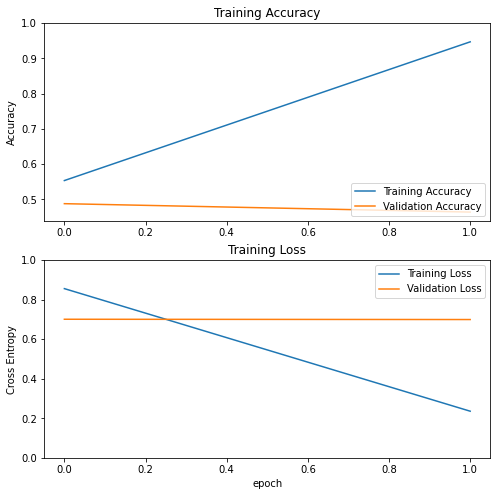

4/4 [==============================] - 0s 8ms/step - loss: 0.7627 - binary_accuracy: 0.0500
Test accuracy: 0.0500
Test loss: 0.7627
TIME TAKEN 283.410466

TRAINING WITH INP 210 and INN 210, TRIAL 1/n
shapes:  211 2208
shape:  420
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
11/11 [==============================] - 6s 342ms/step - loss: 0.7944 - binary_accuracy: 0.4970 - val_loss: 0.7902 - val_binary_accuracy: 0.4286
Epoch 2/2
11/11 [==============================] - 3s 310ms/step - loss: 0.3444 - binary_accuracy: 0.9077 - val_loss: 0.7821 - val_binary_ac

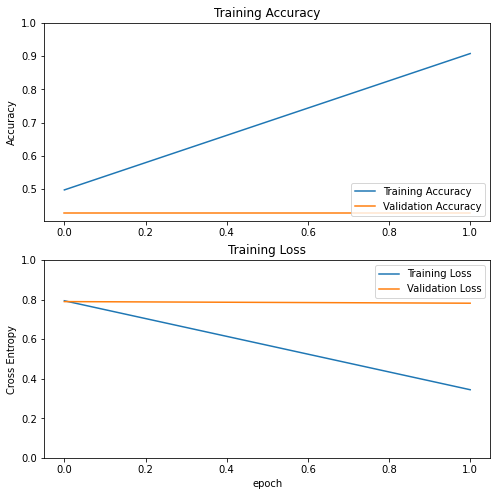

4/4 [==============================] - 0s 9ms/step - loss: 1.0624 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 1.0624
TIME TAKEN 278.355805

TRAINING WITH INP 210 and INN 40, TRIAL 0/n
shapes:  211 2208
shape:  250
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
7/7 [==============================] - 5s 371ms/step - loss: 0.8557 - binary_accuracy: 0.5500 - val_loss: 0.7448 - val_binary_accuracy: 0.2200
Epoch 2/2
7/7 [==============================] - 2s 330ms/step - loss: 0.5543 - binary_accuracy: 0.7350 - val_loss: 0.7606 - val_binary_acc

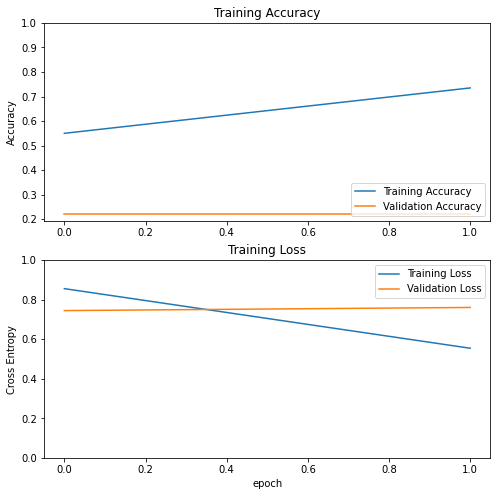

4/4 [==============================] - 0s 10ms/step - loss: 0.8002 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.8002
TIME TAKEN 230.425027

TRAINING WITH INP 210 and INN 40, TRIAL 1/n
shapes:  211 2208
shape:  250
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
7/7 [==============================] - 4s 366ms/step - loss: 0.9855 - binary_accuracy: 0.5000 - val_loss: 0.6517 - val_binary_accuracy: 0.8600
Epoch 2/2
7/7 [==============================] - 2s 330ms/step - loss: 0.6277 - binary_accuracy: 0.7150 - val_loss: 0.6639 - val_binary_ac

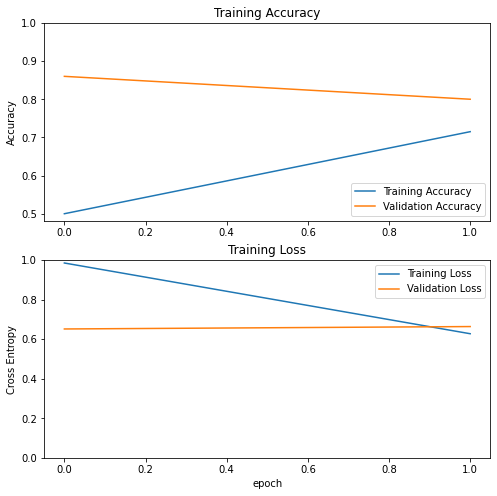

4/4 [==============================] - 0s 10ms/step - loss: 0.6471 - binary_accuracy: 0.8500
Test accuracy: 0.8500
Test loss: 0.6471
TIME TAKEN 232.825587

TRAINING WITH INP 210 and INN 70, TRIAL 0/n
shapes:  211 2208
shape:  280
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
7/7 [==============================] - 4s 352ms/step - loss: 0.8587 - binary_accuracy: 0.4955 - val_loss: 0.6464 - val_binary_accuracy: 0.7143
Epoch 2/2
7/7 [==============================] - 2s 321ms/step - loss: 0.4230 - binary_accuracy: 0.8393 - val_loss: 0.6516 - val_binary_accura

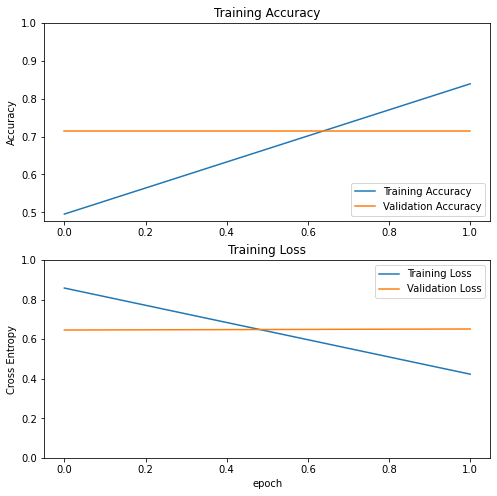

4/4 [==============================] - 0s 9ms/step - loss: 0.5768 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.5768
TIME TAKEN 243.528577

TRAINING WITH INP 210 and INN 70, TRIAL 1/n
shapes:  211 2208
shape:  280
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
7/7 [==============================] - 4s 340ms/step - loss: 0.8260 - binary_accuracy: 0.5670 - val_loss: 0.8175 - val_binary_accuracy: 0.2321
Epoch 2/2
7/7 [==============================] - 2s 306ms/step - loss: 0.3681 - binary_accuracy: 0.8616 - val_loss: 0.8432 - val_binary_accurac

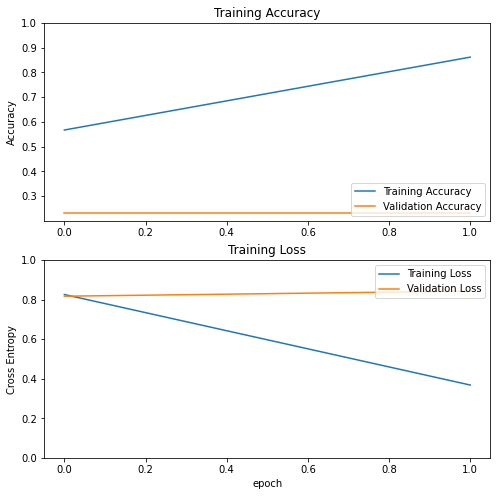

4/4 [==============================] - 0s 10ms/step - loss: 0.9497 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.9497
TIME TAKEN 237.941578

TRAINING WITH INP 210 and INN 100, TRIAL 0/n
shapes:  211 2208
shape:  310
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
8/8 [==============================] - 5s 361ms/step - loss: 0.8548 - binary_accuracy: 0.5202 - val_loss: 0.6258 - val_binary_accuracy: 0.6935
Epoch 2/2
8/8 [==============================] - 3s 331ms/step - loss: 0.3185 - binary_accuracy: 0.9073 - val_loss: 0.6226 - val_binary_a

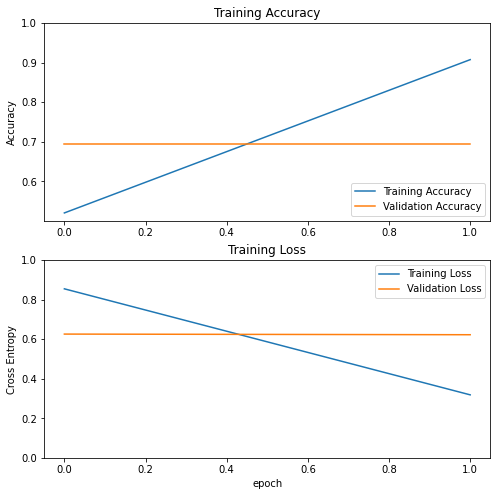

4/4 [==============================] - 0s 9ms/step - loss: 0.4243 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.4243
TIME TAKEN 257.015763

TRAINING WITH INP 210 and INN 100, TRIAL 1/n
shapes:  211 2208
shape:  310
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
8/8 [==============================] - 5s 344ms/step - loss: 0.8600 - binary_accuracy: 0.5282 - val_loss: 0.7769 - val_binary_accuracy: 0.3387
Epoch 2/2
8/8 [==============================] - 3s 318ms/step - loss: 0.3198 - binary_accuracy: 0.9113 - val_loss: 0.7863 - val_binary_accura

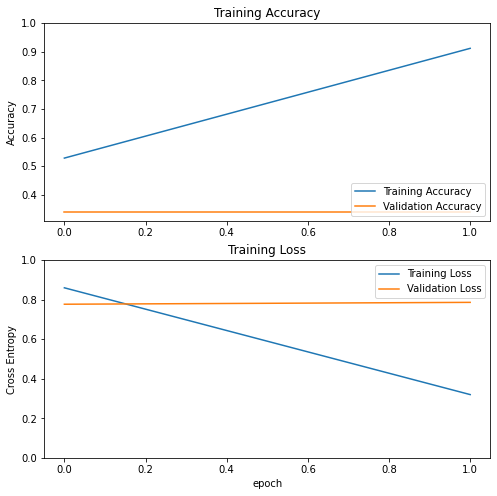

4/4 [==============================] - 0s 9ms/step - loss: 0.9097 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.9097
TIME TAKEN 254.403486

TRAINING WITH INP 210 and INN 130, TRIAL 0/n
shapes:  211 2208
shape:  340
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
9/9 [==============================] - 5s 363ms/step - loss: 0.9651 - binary_accuracy: 0.4743 - val_loss: 0.6622 - val_binary_accuracy: 0.6324
Epoch 2/2
9/9 [==============================] - 3s 326ms/step - loss: 0.2741 - binary_accuracy: 0.9154 - val_loss: 0.6744 - val_binary_ac

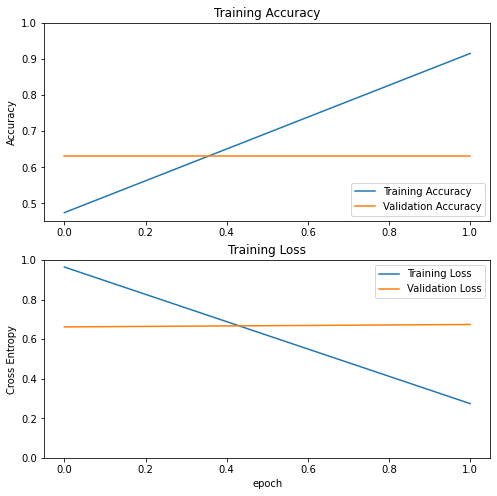

4/4 [==============================] - 0s 10ms/step - loss: 0.6223 - binary_accuracy: 0.8900
Test accuracy: 0.8900
Test loss: 0.6223
TIME TAKEN 263.922446

TRAINING WITH INP 210 and INN 130, TRIAL 1/n
shapes:  211 2208
shape:  340
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
9/9 [==============================] - 5s 340ms/step - loss: 0.9758 - binary_accuracy: 0.5110 - val_loss: 0.7425 - val_binary_accuracy: 0.4265
Epoch 2/2
9/9 [==============================] - 3s 322ms/step - loss: 0.2877 - binary_accuracy: 0.9007 - val_loss: 0.7347 - val_binary_accur

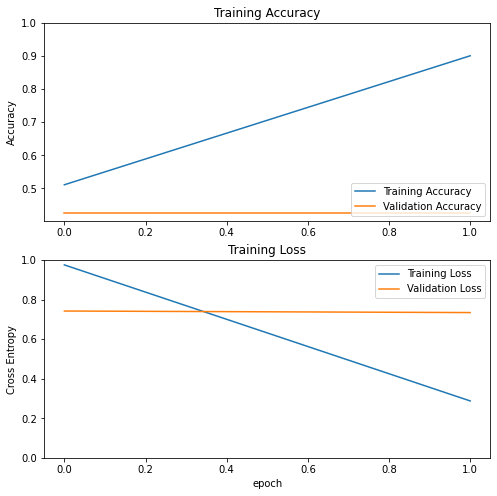

4/4 [==============================] - 0s 9ms/step - loss: 0.8484 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.8484
TIME TAKEN 258.513690

TRAINING WITH INP 210 and INN 160, TRIAL 0/n
shapes:  211 2208
shape:  370
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
10/10 [==============================] - 10s 355ms/step - loss: 0.8824 - binary_accuracy: 0.5507 - val_loss: 0.7151 - val_binary_accuracy: 0.4459
Epoch 2/2
10/10 [==============================] - 3s 325ms/step - loss: 0.2826 - binary_accuracy: 0.8953 - val_loss: 0.7049 - val_bina

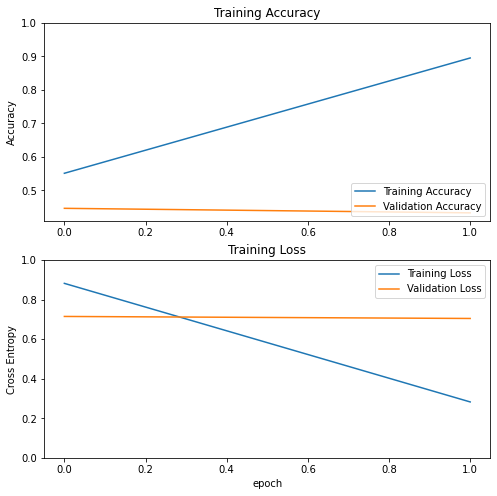

4/4 [==============================] - 0s 9ms/step - loss: 0.7435 - binary_accuracy: 0.0600
Test accuracy: 0.0600
Test loss: 0.7435
TIME TAKEN 272.278006

TRAINING WITH INP 210 and INN 160, TRIAL 1/n
shapes:  211 2208
shape:  370
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
10/10 [==============================] - 5s 350ms/step - loss: 0.8846 - binary_accuracy: 0.4899 - val_loss: 0.7408 - val_binary_accuracy: 0.5135
Epoch 2/2
10/10 [==============================] - 3s 327ms/step - loss: 0.3456 - binary_accuracy: 0.8649 - val_loss: 0.7473 - val_binary_ac

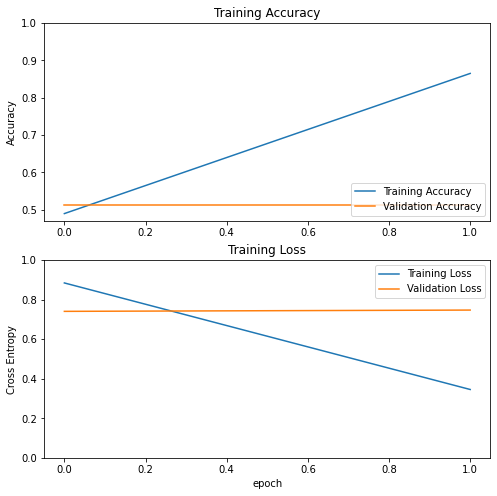

4/4 [==============================] - 0s 11ms/step - loss: 0.4024 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.4024
TIME TAKEN 267.695905

TRAINING WITH INP 210 and INN 190, TRIAL 0/n
shapes:  211 2208
shape:  400
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
10/10 [==============================] - 8s 330ms/step - loss: 0.9651 - binary_accuracy: 0.4750 - val_loss: 0.6839 - val_binary_accuracy: 0.5625
Epoch 2/2
10/10 [==============================] - 3s 316ms/step - loss: 0.2890 - binary_accuracy: 0.9219 - val_loss: 0.6862 - val_binary_a

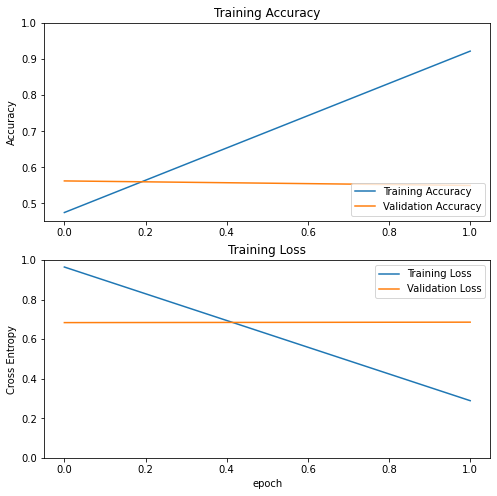

4/4 [==============================] - 0s 11ms/step - loss: 0.6523 - binary_accuracy: 0.8600
Test accuracy: 0.8600
Test loss: 0.6523
TIME TAKEN 281.438192

TRAINING WITH INP 210 and INN 190, TRIAL 1/n
shapes:  211 2208
shape:  400
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
10/10 [==============================] - 6s 331ms/step - loss: 0.8777 - binary_accuracy: 0.5437 - val_loss: 0.7759 - val_binary_accuracy: 0.4750
Epoch 2/2
10/10 [==============================] - 3s 304ms/step - loss: 0.2759 - binary_accuracy: 0.9062 - val_loss: 0.7281 - val_binary_a

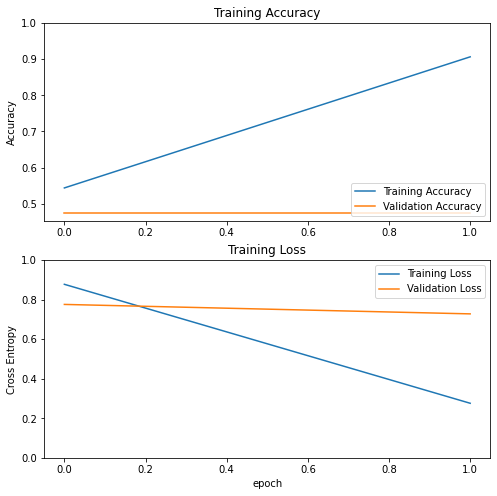

4/4 [==============================] - 0s 10ms/step - loss: 1.0016 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 1.0016
TIME TAKEN 272.576679

TRAINING WITH INP 210 and INN 210, TRIAL 0/n
shapes:  211 2208
shape:  420
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
11/11 [==============================] - 9s 353ms/step - loss: 0.8760 - binary_accuracy: 0.5149 - val_loss: 0.7305 - val_binary_accuracy: 0.4643
Epoch 2/2
11/11 [==============================] - 4s 321ms/step - loss: 0.3355 - binary_accuracy: 0.8899 - val_loss: 0.7106 - val_bina

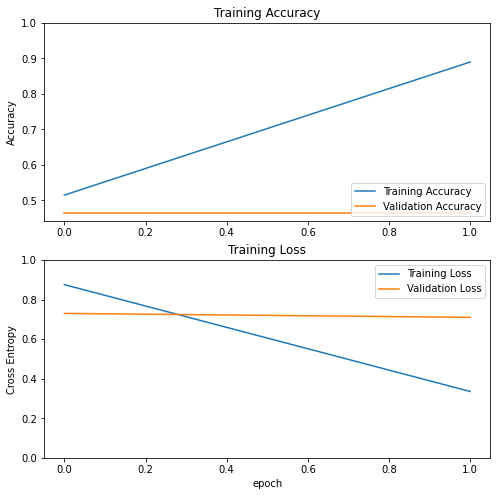

4/4 [==============================] - 0s 10ms/step - loss: 0.5578 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.5578
TIME TAKEN 277.969071

TRAINING WITH INP 210 and INN 210, TRIAL 1/n
shapes:  211 2208
shape:  420
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
11/11 [==============================] - 6s 343ms/step - loss: 0.8508 - binary_accuracy: 0.5030 - val_loss: 0.6904 - val_binary_accuracy: 0.5000
Epoch 2/2
11/11 [==============================] - 4s 327ms/step - loss: 0.2659 - binary_accuracy: 0.9286 - val_loss: 0.6839 - val_binary_a

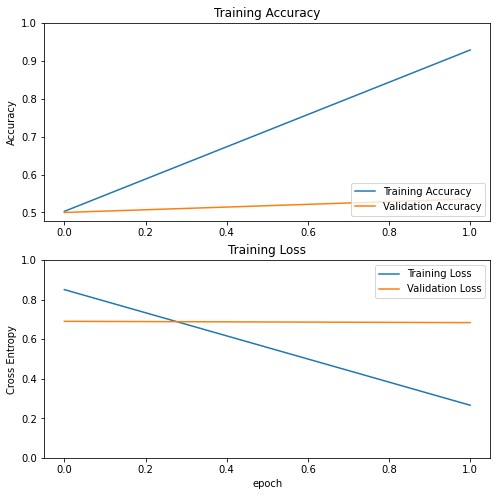

4/4 [==============================] - 0s 11ms/step - loss: 0.6785 - binary_accuracy: 0.6700
Test accuracy: 0.6700
Test loss: 0.6785
TIME TAKEN 276.891810

TRAINING WITH INP 210 and INN 280, TRIAL 0/n
shapes:  211 2208
shape:  490
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
13/13 [==============================] - 6s 344ms/step - loss: 0.9612 - binary_accuracy: 0.4643 - val_loss: 0.6861 - val_binary_accuracy: 0.5816
Epoch 2/2
13/13 [==============================] - 4s 326ms/step - loss: 0.3537 - binary_accuracy: 0.8622 - val_loss: 0.6805 - val_binary_a

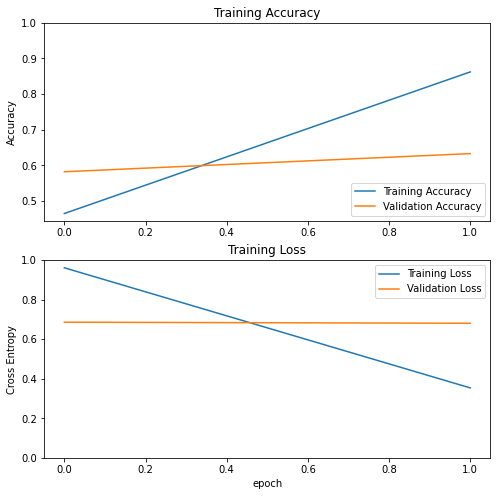

4/4 [==============================] - 0s 12ms/step - loss: 0.7084 - binary_accuracy: 0.3600
Test accuracy: 0.3600
Test loss: 0.7084
TIME TAKEN 302.499808

TRAINING WITH INP 210 and INN 280, TRIAL 1/n
shapes:  211 2208
shape:  490
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
13/13 [==============================] - 7s 356ms/step - loss: 0.8536 - binary_accuracy: 0.5230 - val_loss: 0.7488 - val_binary_accuracy: 0.5306
Epoch 2/2
13/13 [==============================] - 4s 335ms/step - loss: 0.3375 - binary_accuracy: 0.8673 - val_loss: 0.7075 - val_binary_a

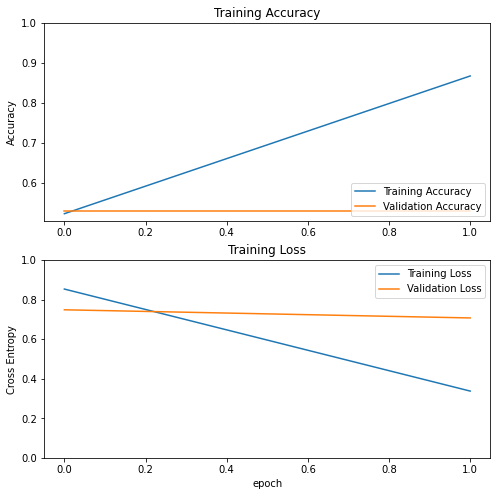

4/4 [==============================] - 0s 11ms/step - loss: 1.0058 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 1.0058
TIME TAKEN 301.118247

TRAINING WITH INP 210 and INN 350, TRIAL 0/n
shapes:  211 2208
shape:  560
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
14/14 [==============================] - 6s 324ms/step - loss: 0.8088 - binary_accuracy: 0.5469 - val_loss: 0.6672 - val_binary_accuracy: 0.6161
Epoch 2/2
14/14 [==============================] - 4s 303ms/step - loss: 0.3335 - binary_accuracy: 0.8839 - val_loss: 0.6649 - val_bina

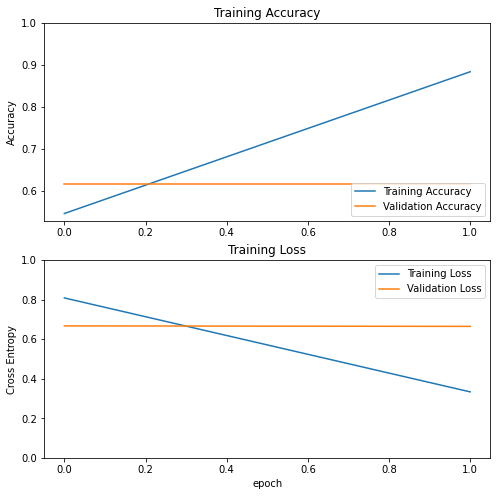

4/4 [==============================] - 0s 10ms/step - loss: 0.9588 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.9588
TIME TAKEN 328.522551

TRAINING WITH INP 210 and INN 350, TRIAL 1/n
shapes:  211 2208
shape:  560
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
14/14 [==============================] - 6s 331ms/step - loss: 0.9106 - binary_accuracy: 0.4754 - val_loss: 0.6423 - val_binary_accuracy: 0.6786
Epoch 2/2
14/14 [==============================] - 4s 314ms/step - loss: 0.3523 - binary_accuracy: 0.8750 - val_loss: 0.6499 - val_bina

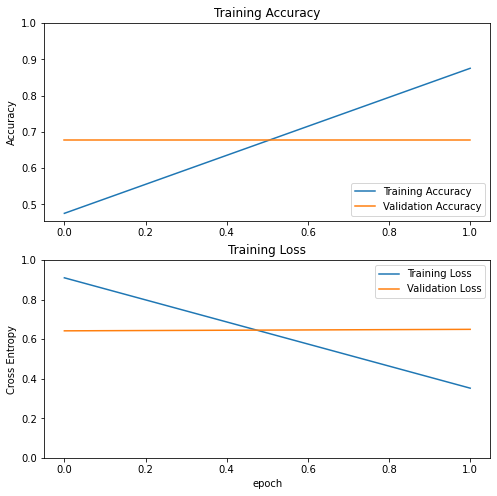

4/4 [==============================] - 0s 11ms/step - loss: 0.9364 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.9364
TIME TAKEN 326.944977

TRAINING WITH INP 210 and INN 420, TRIAL 0/n
shapes:  211 2208
shape:  630
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
16/16 [==============================] - 7s 329ms/step - loss: 0.9056 - binary_accuracy: 0.4861 - val_loss: 0.6348 - val_binary_accuracy: 0.6667
Epoch 2/2
16/16 [==============================] - 5s 317ms/step - loss: 0.4148 - binary_accuracy: 0.8056 - val_loss: 0.6490 - val_bina

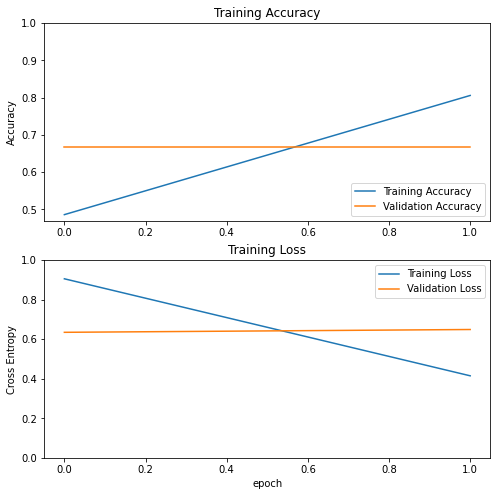

4/4 [==============================] - 0s 9ms/step - loss: 0.9155 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.9155
TIME TAKEN 328.032624

TRAINING WITH INP 210 and INN 420, TRIAL 1/n
shapes:  211 2208
shape:  630
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
16/16 [==============================] - 7s 342ms/step - loss: 0.9026 - binary_accuracy: 0.5258 - val_loss: 0.6185 - val_binary_accuracy: 0.6905
Epoch 2/2
16/16 [==============================] - 5s 327ms/step - loss: 0.4072 - binary_accuracy: 0.8135 - val_loss: 0.6193 - val_binar

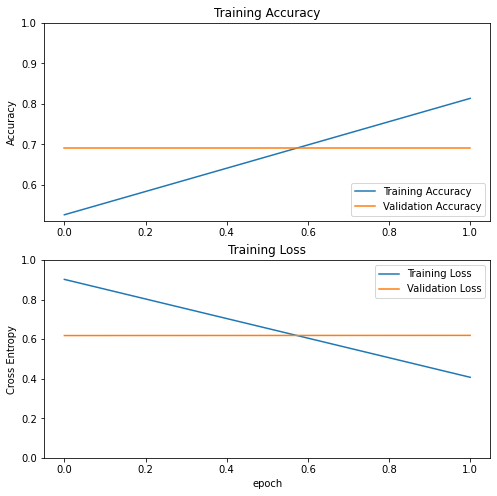

4/4 [==============================] - 0s 10ms/step - loss: 1.0533 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 1.0533
TIME TAKEN 342.785808

TRAINING WITH INP 210 and INN 560, TRIAL 0/n
shapes:  211 2208
shape:  770
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
20/20 [==============================] - 9s 340ms/step - loss: 0.9148 - binary_accuracy: 0.4968 - val_loss: 0.6469 - val_binary_accuracy: 0.7208
Epoch 2/2
20/20 [==============================] - 7s 328ms/step - loss: 0.6081 - binary_accuracy: 0.6607 - val_loss: 0.7050 - val_bina

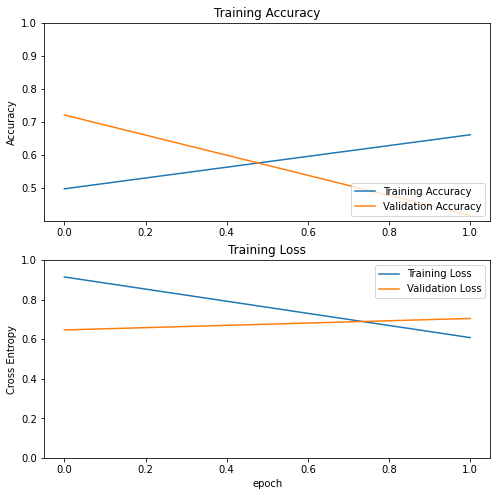

4/4 [==============================] - 0s 10ms/step - loss: 0.6803 - binary_accuracy: 0.6600
Test accuracy: 0.6600
Test loss: 0.6803
TIME TAKEN 365.466820

TRAINING WITH INP 210 and INN 560, TRIAL 1/n
shapes:  211 2208
shape:  770
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
20/20 [==============================] - 9s 335ms/step - loss: 0.9356 - binary_accuracy: 0.4951 - val_loss: 0.6049 - val_binary_accuracy: 0.7727
Epoch 2/2
20/20 [==============================] - 6s 320ms/step - loss: 0.5019 - binary_accuracy: 0.7532 - val_loss: 0.6326 - val_binary_a

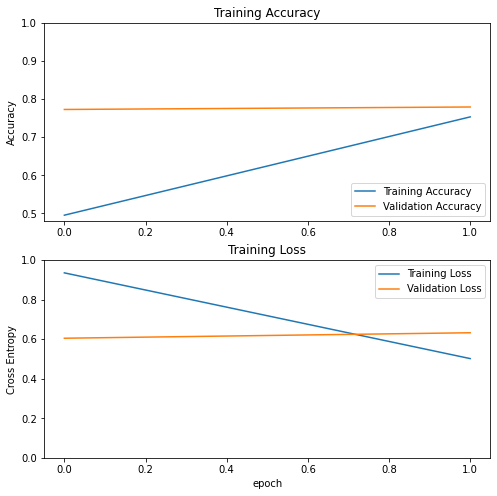

4/4 [==============================] - 0s 10ms/step - loss: 0.8309 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.8309
TIME TAKEN 369.795955

TRAINING WITH INP 210 and INN 700, TRIAL 0/n
shapes:  211 2208
shape:  910
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
23/23 [==============================] - 9s 328ms/step - loss: 0.8565 - binary_accuracy: 0.5082 - val_loss: 0.7323 - val_binary_accuracy: 0.2637
Epoch 2/2
23/23 [==============================] - 8s 328ms/step - loss: 0.6075 - binary_accuracy: 0.6497 - val_loss: 0.7429 - val_bina

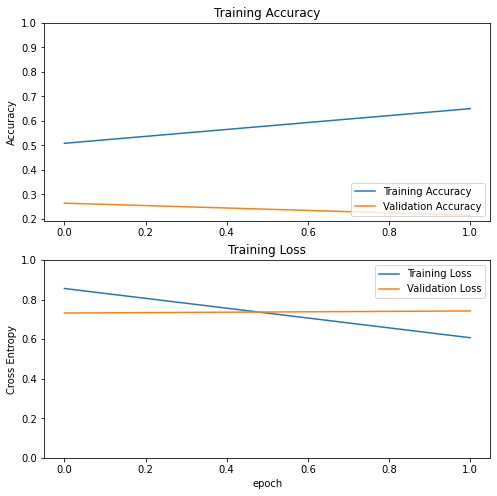

4/4 [==============================] - 0s 11ms/step - loss: 0.5959 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.5959
TIME TAKEN 409.798193

TRAINING WITH INP 210 and INN 700, TRIAL 1/n
shapes:  211 2208
shape:  910
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
23/23 [==============================] - 9s 325ms/step - loss: 0.9032 - binary_accuracy: 0.5082 - val_loss: 1.0375 - val_binary_accuracy: 0.2308
Epoch 2/2
23/23 [==============================] - 7s 318ms/step - loss: 0.5320 - binary_accuracy: 0.7198 - val_loss: 0.6756 - val_binary_a

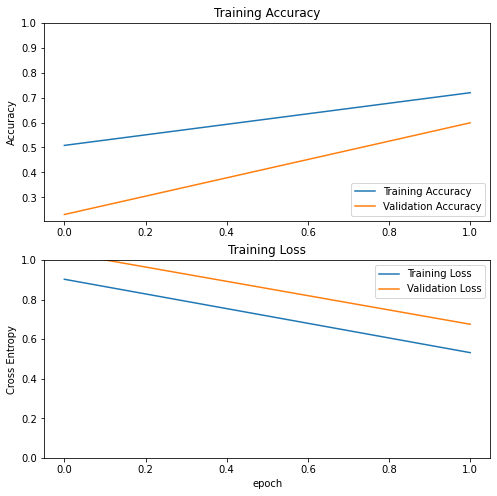

4/4 [==============================] - 0s 11ms/step - loss: 0.6989 - binary_accuracy: 0.4800
Test accuracy: 0.4800
Test loss: 0.6989
TIME TAKEN 406.042151

TRAINING WITH INP 210 and INN 900, TRIAL 0/n
shapes:  211 2208
shape:  1110
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
28/28 [==============================] - 11s 318ms/step - loss: 0.7621 - binary_accuracy: 0.5372 - val_loss: 0.6091 - val_binary_accuracy: 0.8333
Epoch 2/2
28/28 [==============================] - 9s 312ms/step - loss: 0.6072 - binary_accuracy: 0.6734 - val_loss: 0.6961 - val_binary

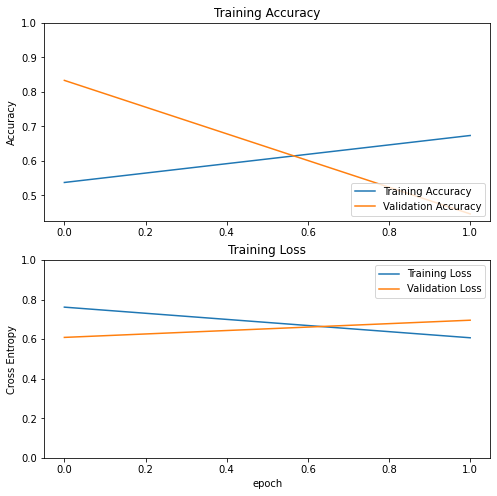

4/4 [==============================] - 0s 11ms/step - loss: 0.6933 - binary_accuracy: 0.5000
Test accuracy: 0.5000
Test loss: 0.6933
TIME TAKEN 473.343256

TRAINING WITH INP 210 and INN 900, TRIAL 1/n
shapes:  211 2208
shape:  1110
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
28/28 [==============================] - 11s 336ms/step - loss: 0.8857 - binary_accuracy: 0.5056 - val_loss: 0.6290 - val_binary_accuracy: 0.8063
Epoch 2/2
28/28 [==============================] - 9s 327ms/step - loss: 0.6195 - binary_accuracy: 0.6768 - val_loss: 0.7366 - val_binary

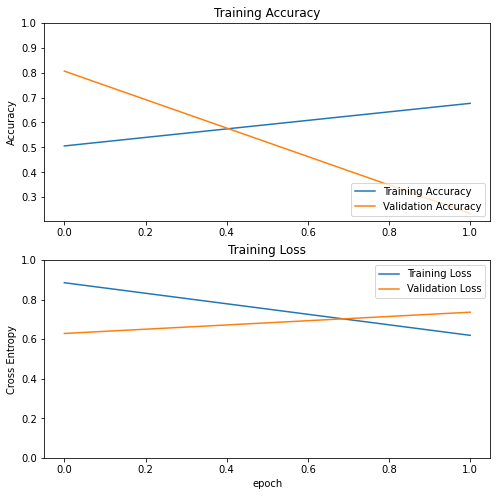

4/4 [==============================] - 0s 10ms/step - loss: 0.6249 - binary_accuracy: 0.9300
Test accuracy: 0.9300
Test loss: 0.6249
TIME TAKEN 455.237167

TRAINING WITH INP 210 and INN 1200, TRIAL 0/n
shapes:  211 2208
shape:  1410
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
36/36 [==============================] - 16s 336ms/step - loss: 0.8328 - binary_accuracy: 0.5426 - val_loss: 0.6523 - val_binary_accuracy: 0.8582
Epoch 2/2
36/36 [==============================] - 11s 315ms/step - loss: 0.6431 - binary_accuracy: 0.6454 - val_loss: 0.7379 - val_bina

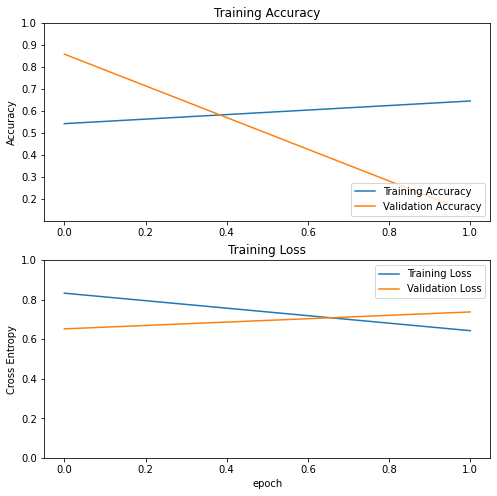

4/4 [==============================] - 0s 11ms/step - loss: 0.6374 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.6374
TIME TAKEN 542.400779

TRAINING WITH INP 210 and INN 1200, TRIAL 1/n
shapes:  211 2208
shape:  1410
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Epoch 1/2
36/36 [==============================] - 13s 321ms/step - loss: 0.7815 - binary_accuracy: 0.5363 - val_loss: 0.6140 - val_binary_accuracy: 0.8652
Epoch 2/2
36/36 [==============================] - 11s 317ms/step - loss: 0.6471 - binary_accuracy: 0.6605 - val_loss: 0.5518 - val_bina

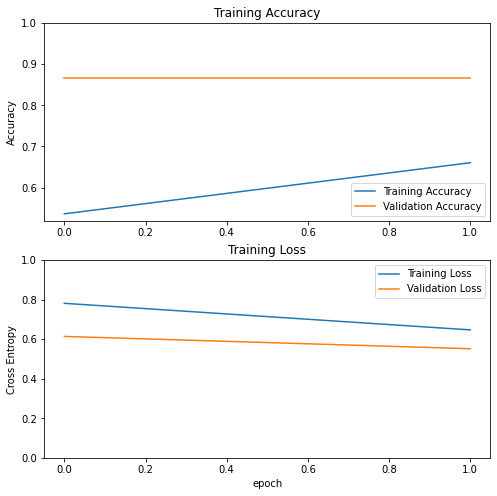

4/4 [==============================] - 0s 10ms/step - loss: 0.9522 - binary_accuracy: 0.0000e+00
Test accuracy: 0.0000
Test loss: 0.9522
TIME TAKEN 541.107287



In [23]:
for inp, inn in datatrain_conf:
    for trial in range(2):
      print("TRAINING WITH INP %d and INN %d, TRIAL %d/n" % (inp, inn, trial))
      start = time.time()
      set_df = get_posneg(data_df, positive=inp, negative=inn, key_loc=1) #210 positives 
      test_df = load_dataset(files=test_files, cols="B", positive=True)
      test_setdf = get_posneg(test_df, positive=100, negative=0, key_loc=1)

      # EXTRACTING FEATURES

      train_features = set_df.copy()
      train_labels = train_features.pop("Ground-Truth")
      train_features = features(train_features["Sentence"].tolist())

      test_features = test_setdf.copy()
      test_labels = test_features.pop("Ground-Truth")
      test_features = features(test_features["Sentence"].tolist())
      
      RNN_arg = arg_rnn()
      RNN_model = build_RNN(RNN_arg)
      X1_train = np.array(train_features)
      X2_train = np.array(train_labels)
      history = RNN_model.fit(X1_train, X2_train, validation_split=0.2, epochs=2) #[:train_border]
      print("TRAINING DONE")

      evaluate(history)
      test_loss, test_accuracy = RNN_model.evaluate(np.asarray(test_features), np.array(test_labels))
      print(f'Test accuracy: {test_accuracy:.4f}')
      print(f'Test loss: {test_loss:.4f}')
      result.append((test_loss, test_accuracy))
      print("TIME TAKEN %f\n" % (time.time()-start))

In [24]:
result

[(0.7298387289047241, 0.20999999344348907),
 (0.6896071434020996, 0.47999998927116394),
 (0.7891523838043213, 0.019999999552965164),
 (0.5998676419258118, 1.0),
 (0.8440188765525818, 0.0),
 (0.6521412134170532, 0.800000011920929),
 (0.4321622848510742, 1.0),
 (0.49915561079978943, 1.0),
 (0.4137205183506012, 1.0),
 (0.6059057712554932, 1.0),
 (0.5763387084007263, 1.0),
 (0.7979357838630676, 0.03999999910593033),
 (0.7627435326576233, 0.05000000074505806),
 (1.0624306201934814, 0.0),
 (0.800157368183136, 0.0),
 (0.647146999835968, 0.8500000238418579),
 (0.5768432021141052, 1.0),
 (0.9497320652008057, 0.0),
 (0.4242793619632721, 1.0),
 (0.9097244143486023, 0.0),
 (0.622282862663269, 0.8899999856948853),
 (0.848418653011322, 0.0),
 (0.7434545159339905, 0.05999999865889549),
 (0.40244969725608826, 1.0),
 (0.6522659063339233, 0.8600000143051147),
 (1.0016146898269653, 0.0),
 (0.5577826499938965, 1.0),
 (0.67848801612854, 0.6700000166893005),
 (0.7084113955497742, 0.36000001430511475),
 (1.0

In [ ]:

RNN_arg = arg_rnn()
RNN_model = build_RNN(RNN_arg)
X1_train = np.array(train_features)
X2_train = np.array(train_labels)
history = RNN_model.fit(X1_train, X2_train, validation_split=0.2, epochs=2) #[:train_border]
print("DONE")
# early = EarlyStopping(monitor="val_loss", mode="min", patience=20)
# model.fit([X1_train, X2_train], y_train, batch_size=args_rnn.batch_size, epochs=args_rnn.epochs,
#           validation_split=0.1, callbacks=[early])

# BUG FOUND IN USING TF-IDF


Epoch 1/4
12/12 [==============================] - 8s 523ms/step - loss: 0.8492 - binary_accuracy: 0.5238 - val_loss: 0.7791 - val_binary_accuracy: 0.4286
Epoch 2/4
12/12 [==============================] - 6s 507ms/step - loss: 0.3439 - binary_accuracy: 0.8836 - val_loss: 0.7720 - val_binary_accuracy: 0.4286
Epoch 3/4
12/12 [==============================] - 6s 492ms/step - loss: 0.1658 - binary_accuracy: 0.9868 - val_loss: 0.7791 - val_binary_accuracy: 0.4286
Epoch 4/4
12/12 [==============================] - 6s 484ms/step - loss: 0.0791 - binary_accuracy: 1.0000 - val_loss: 0.8049 - val_binary_accuracy: 0.4286
DONE


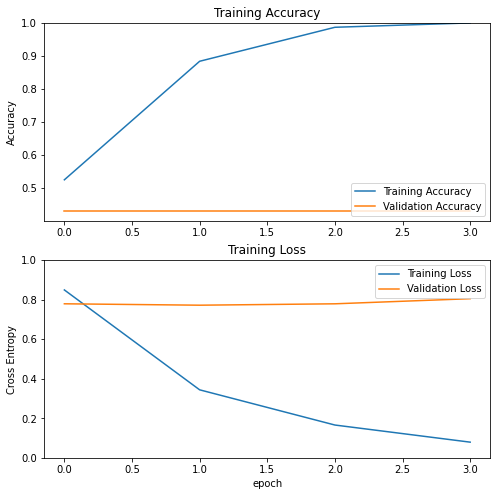

4/4 [==============================] - 0s 9ms/step - loss: 0.4318 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.4318


In [ ]:
evaluate(history)
test_loss, test_accuracy = RNN_model.evaluate(np.asarray(test_features), np.array(test_labels))
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

In [ ]:
prediction = np.squeeze(RNN_model.predict(np.asarray(test_features)) ) #numpy.ndarray df_features[train_border:]
truth =  np.asarray(test_labels)# np.asarray(X2_train[train_border:]) #numpy.ndarray
result = np.asarray((prediction > 0.5)==truth)
output_temp = pd.DataFrame({'prediction': prediction, 'truth': truth, 'result': result}, columns=['prediction', 'truth', 'result'] )
pd.set_option('display.max_rows', None)
print(output_temp[0:100])
pd.set_option('display.max_rows', 10)


#LET'S USE THE MODEL AS A BASELINE FOR SUICIDAL CLASSIFICARTION

In [ ]:

# RNN_model.trainable = False
# MNT_model = tf.keras.Sequential([
#     RNN_model,
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(1,activation='sigmoid')
# ])

# MNT_model.compile(
#     optimizer = 'RMSprop',
#     loss = 'binary_crossentropy',
#     metrics = ['accuracy']
# )


In [ ]:
# history = MNT_model.fit(
#     np.asarray(bow_features_kaggle),
#     np.asarray(train_labels_kaggle)
#     validation_split=0.1
#     epochs=10
# )


In [ ]:
# Evaluation Part
# v, bowtestKaggle_features, tfidftestKaggle_features = BOW_TFIDF(test_sentences_kaggle)


In [ ]:
# test_loss, test_accuracy = MNT_model.evaluate(np.asarray(bowtestKaggle_features), np.asarray(test_labels_kaggle))

# print(f'Test accuracy: {test_accuracy:.4f}')
# print(f'Test loss: {test_loss:.4f}')

#LSTM

In [ ]:
# import numpy as np
# from tqdm import tqdm
# from tabulate import tabulate
# from sklearn.model_selection import KFold
# from keras.models import Model
# from keras.layers import Dense, Embedding, Input
# from keras.layers import LSTM, GlobalMaxPool1D, Dropout, BatchNormalization
# from keras.preprocessing import text, sequence
# from keras.callbacks import EarlyStopping

In [ ]:
# def build_LSTM(args):
#     # From XiongJi's Github
#     inp = Input(shape=(args.max_seq_len, ))
#     # x = Embedding(input_dim=args.max_num_words, output_dim=args.embedding_dim)(inp)
#     # x = LSTM(units=args.lstm_units, activation='tanh', dropout=args.dropout_rate, return_sequences=True)(x)
#     # x = GlobalMaxPool1D()(x)
#     # x = Dropout(args.dropout_rate)(x)
#     # x = BatchNormalization()(x)
#     # x = Dense(args.dense_units, activation="relu")(x)
#     # x = Dropout(args.dropout_rate)(x)
#     # x = BatchNormalization()(x)
#     # x = Dense(1, activation="sigmoid")(x)

#     # TODO: Nabila, please modify this part use tf.keras instead of keras.model
#     # model = tf.keras.Sequential([
#     #     tf.keras.layers.Dense(16,activation='relu',input_shape=(NUM_WORDS,)),
#     # ])

#     model = Model(inputs=inp, outputs=x)

#     model.compile(
#         loss='binary_crossentropy', 
#         # OR 'sparse_categorical_crossentropy' for multiclassifcation
#         optimizer='adam', 
#         # OR 'RMSprop'
#         metrics=['accuracy'])
#     return model
